### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# Mitigação de erros (com pós-processamento)
Usando as instruções em (https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html), podemos calibrar medidas em uma base completa, medir desvios dos resultados esperados e então corrigir resultados posteriores baseados nesses desvios.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
qr = QuantumRegister(5)
qubit_list = [2, 3, 4] # os qubits para os quais aplicaremos calibracao de medidas
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)

In [3]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [14]:
meas_calibs # circuitos que serao executados para obter dados para calibracao (uma para cada state_labels)

## Cálculo da matriz de calibração

In [5]:
nshots = 8192
simulator = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend = simulator, shots = nshots) # executa a calibracao
cal_results = job.result()

In [6]:
# a matriz de calibracao sem ruido e a identidade
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [7]:
provider = IBMQ.load_account()
device = provider.get_backend('ibmq_bogota')
noise_model = NoiseModel.from_backend(device)

In [8]:
job = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model)
cal_results = job.result()

In [10]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
print(meas_fitter.cal_matrix)

[[9.44824219e-01 4.00390625e-02 1.60888672e-01 8.42285156e-03
  3.67431641e-02 8.54492188e-04 5.49316406e-03 3.66210938e-04]
 [1.55029297e-02 9.24194336e-01 2.68554688e-03 1.65283203e-01
  3.66210938e-04 3.43017578e-02 0.00000000e+00 5.12695312e-03]
 [2.79541016e-02 9.76562500e-04 8.12377930e-01 3.82080078e-02
  6.10351562e-04 1.22070312e-04 3.14941406e-02 1.95312500e-03]
 [3.66210938e-04 2.55126953e-02 1.39160156e-02 7.77954102e-01
  0.00000000e+00 9.76562500e-04 6.10351562e-04 2.84423828e-02]
 [1.11083984e-02 1.22070312e-04 1.58691406e-03 0.00000000e+00
  9.24804688e-01 4.27246094e-02 1.59545898e-01 6.34765625e-03]
 [2.44140625e-04 8.78906250e-03 0.00000000e+00 1.95312500e-03
  1.42822266e-02 8.96606445e-01 3.17382812e-03 1.60400391e-01]
 [0.00000000e+00 0.00000000e+00 8.17871094e-03 3.66210938e-04
  2.28271484e-02 1.22070312e-03 7.84423828e-01 3.73535156e-02]
 [0.00000000e+00 3.66210938e-04 3.66210938e-04 7.81250000e-03
  3.66210938e-04 2.31933594e-02 1.52587891e-02 7.60009766e-01]]

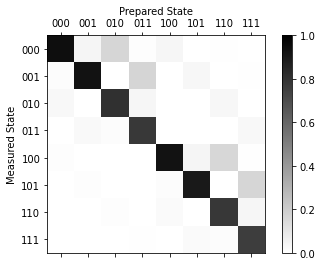

In [11]:
# visualizacao grafica da matriz de calibracao
meas_fitter.plot_calibration()

## Aplicando a calibração

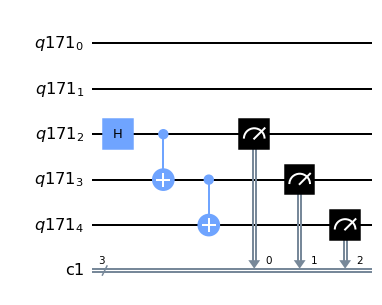

In [12]:
qr = QuantumRegister(5); cr = ClassicalRegister(3); qc_ghz = QuantumCircuit(qr, cr)
qc_ghz.h(qr[2]); qc_ghz.cx(qr[2], qr[3]); qc_ghz.cx(qr[3], qr[4])
qc_ghz.measure(qr[2], cr[0]); qc_ghz.measure(qr[3], cr[1]); qc_ghz.measure(qr[4], cr[2]);
qc_ghz.draw(output = 'mpl')

In [14]:
qubit_list = [2, 3, 4] # os qubits para os quais aplicaremos calibracao de medidas
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)

In [15]:
job = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model)
cal_results = job.result()

In [16]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

In [17]:
job = execute(qc_ghz, backend = simulator, shots = nshots, noise_model = noise_model)
unmitigated_counts = job.result().get_counts() # resultados sem mitigacao de erros

In [18]:
# Resultados com mitigacao de erros
mitigated_results = meas_fitter.filter.apply(job.result())
mitigated_counts = mitigated_results.get_counts()

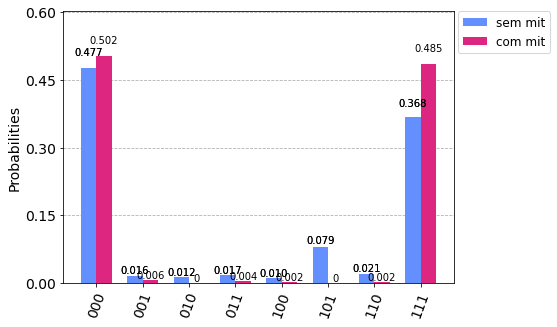

In [20]:
plot_histogram([unmitigated_counts, mitigated_counts], legend=['sem mit', 'com mit'])

## Tomografia de estado com mitigação de erros, com ruído simulado

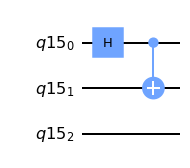

In [25]:
qr = QuantumRegister(3); qc = QuantumCircuit(qr); qc.h([0]); qc.cx([0], [1])
qc.draw(output = 'mpl')

In [26]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

In [28]:
qstc = state_tomography_circuits(qc, [qr[0], qr[1]])
job = execute(qstc, backend = simulator, shots = nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method = 'lstsq')
print(rho.real)

[[ 4.98195636e-01 -4.40990277e-03  3.89562984e-03  4.98864366e-01]
 [-4.40990277e-03  4.32807485e-04  2.31680965e-04 -3.74944383e-03]
 [ 3.89562984e-03  2.31680965e-04  4.35315346e-04  4.59019673e-03]
 [ 4.98864366e-01 -3.74944383e-03  4.59019673e-03  5.00936242e-01]]


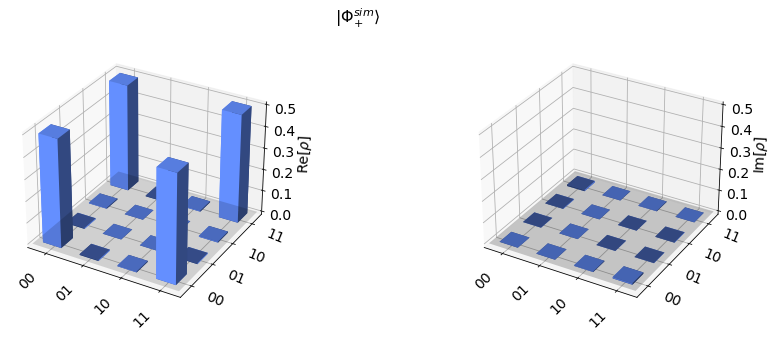

In [29]:
from qiskit.visualization import plot_state_city
plot_state_city(rho, title=r'$|\Phi_{+}^{sim}\rangle$')

In [30]:
device = provider.get_backend('ibmq_bogota')
noise_model = NoiseModel.from_backend(device)
job = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')
print(rho.real)

[[ 0.47736802  0.00451017  0.00828139  0.42361047]
 [ 0.00451017  0.04139741 -0.00148389  0.00612016]
 [ 0.00828139 -0.00148389  0.03852311  0.00987462]
 [ 0.42361047  0.00612016  0.00987462  0.44271146]]


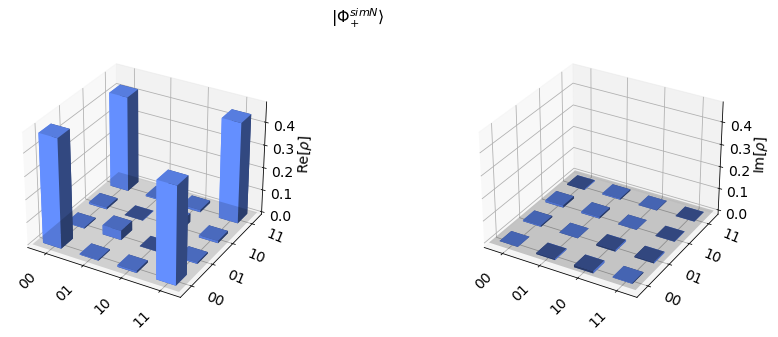

In [31]:
plot_state_city(rho, title=r'$|\Phi_{+}^{simN}\rangle$')

In [32]:
qubit_list = [0, 1] 
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr, circlabel = 'mcal')
job = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = 'mcal')

In [33]:
qstc = state_tomography_circuits(qc, [qr[0], qr[1]])
job = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model)
mitigated_results = meas_fitter.filter.apply(job.result())
qstf = StateTomographyFitter(mitigated_results, qstc)
rho = qstf.fit(method = 'lstsq')
print(rho.real)

[[ 4.99151945e-01  2.95933557e-03  2.39254950e-03  4.88711834e-01]
 [ 2.95933557e-03  7.82217272e-03 -1.78728829e-04  5.66646214e-04]
 [ 2.39254950e-03 -1.78728829e-04  6.25746888e-03 -4.94905023e-04]
 [ 4.88711834e-01  5.66646214e-04 -4.94905023e-04  4.86768413e-01]]


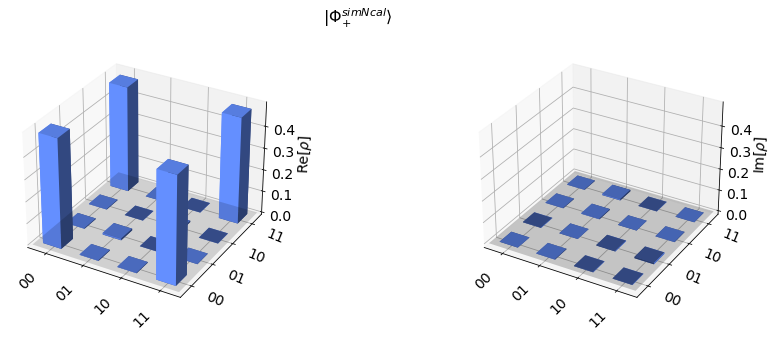

In [34]:
plot_state_city(rho, title=r'$|\Phi_{+}^{simNcal}\rangle$')

## Tomografia de estado com mitigação de erros, no chip real

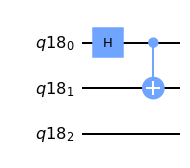

In [42]:
qr = QuantumRegister(3); qc = QuantumCircuit(qr); qc.h([0]); qc.cx([0], [1])
qc.draw(output = 'mpl')

In [43]:
provider = IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_bogota')
from qiskit.tools.monitor import job_monitor

In [44]:
qstc = state_tomography_circuits(qc, [qr[0], qr[1]])
job_exp = execute(qstc, backend = device, shots = nshots); job_monitor(job_exp)
qstf = StateTomographyFitter(job_exp.result(), qstc)
rho = qstf.fit(method = 'lstsq'); print(rho.real)

Job Status: job has successfully run
[[0.47231205 0.02000599 0.02563442 0.39505897]
 [0.02000599 0.04905997 0.00305607 0.01235205]
 [0.02563442 0.00305607 0.05004285 0.02266414]
 [0.39505897 0.01235205 0.02266414 0.42858512]]


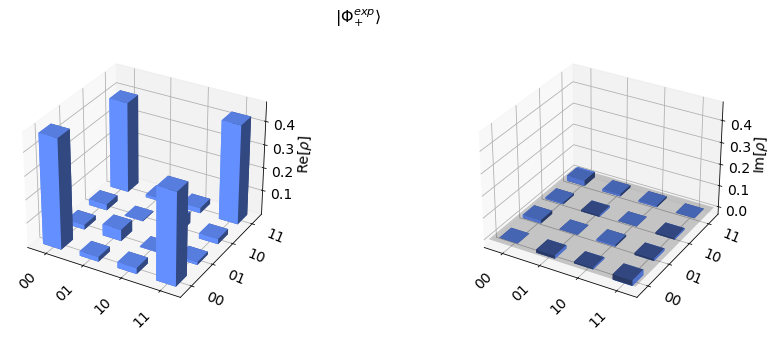

In [45]:
plot_state_city(rho, title=r'$|\Phi_{+}^{exp}\rangle$')

In [39]:
qr = QuantumRegister(3)
qubit_list = [0, 1] # os qubits para os quais aplicaremos calibracao de medidas
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)
job = execute(meas_calibs, backend = device, shots = nshots)
job_monitor(job)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

Job Status: job has successfully run


In [46]:
mitigated_results = meas_fitter.filter.apply(job_exp.result())
qstf = StateTomographyFitter(mitigated_results, qstc)
rho = qstf.fit(method = 'lstsq'); print(rho.real)

[[4.93587976e-01 1.12084948e-02 1.62978032e-02 4.73031572e-01]
 [1.12084948e-02 9.24302965e-03 1.64332976e-04 3.85132678e-03]
 [1.62978032e-02 1.64332976e-04 1.26266742e-02 1.81489455e-02]
 [4.73031572e-01 3.85132678e-03 1.81489455e-02 4.84542321e-01]]


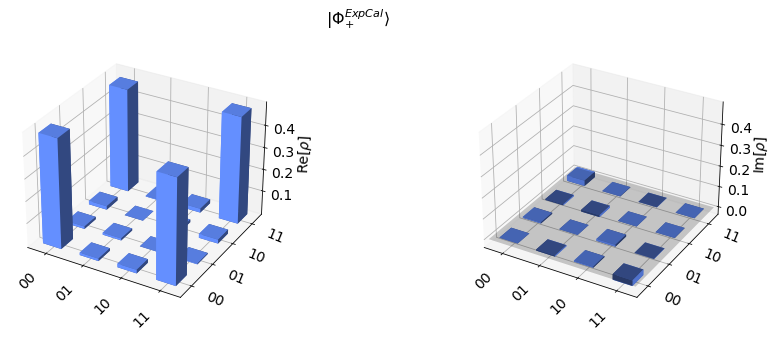

In [47]:
plot_state_city(rho, title=r'$|\Phi_{+}^{ExpCal}\rangle$')

Tenho a impressão que, em geral, a mitigação diminui o erro dos elemento de $\rho$ de uma ordem de grandeza.